In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
naics_map = {
        '11': 'Agricultura, Pesca y Minería',
        '21': 'Minería y Extracción',
        '22': 'Servicios Públicos',
        '23': 'Construcción',
        '31': 'Manufactura',
        '32': 'Manufactura',
        '33': 'Manufactura',
        '42': 'Comercio Mayorista',
        '44': 'Comercio Minorista',
        '45': 'Comercio Minorista',
        '48': 'Transporte y Almacenamiento',
        '49': 'Transporte y Almacenamiento',
        '51': 'Información y Tecnología',
        '52': 'Finanzas y Seguros',
        '53': 'Bienes Raíces',
        '54': 'Servicios Profesionales y Técnicos',
        '55': 'Administración de Empresas',
        '56': 'Servicios Administrativos y Apoyo',
        '61': 'Educación',
        '62': 'Salud y Asistencia Social',
        '71': 'Arte, Entretenimiento y Recreación',
        '72': 'Alojamiento y Servicios Alimenticios',
        '81': 'Otros Servicios',
        '92': 'Administración Pública'
}

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import re

# 1. Carga de Datos
def load_data(file_path):
    return pd.read_excel("datos/EXPORT.xlsx", skiprows=7)

# 2. Selección Inicial de Variables (Basada en EDA)
def initial_variable_selection(df):
    # Variables seleccionadas según el EDA
    selected_variables = [
        "Company",
        "Cash and Cash Equivalents",    
        "Export",
        "Import",
        "Industry (NAICS)",
        "Long term Debt",
        "Net Sales Revenue Trend (%)",
        "Number of Employees",
        "Operating Profit Trend (%)",
        "Property, plant and equipment",
        "Return on Assets (ROA) (%)",
        "Return on Equity (ROE) (%)",
        "Quick Ratio (x)",
        "Short Term Debt",      
        "Total operating revenue",
    ]
    return df[selected_variables]

def clean_data(df):
    # Identificar columnas categóricas y numéricas
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Imputación para columnas numéricas
    if len(numeric_columns) > 0:
        numeric_imputer = SimpleImputer(strategy='median')
        df[numeric_columns] = pd.DataFrame(
            numeric_imputer.fit_transform(df[numeric_columns]),
            columns=numeric_columns,
            index=df.index
        )
    
    # Imputación para columnas categóricas
    if len(categorical_columns) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_columns] = pd.DataFrame(
            categorical_imputer.fit_transform(df[categorical_columns]),
            columns=categorical_columns,
            index=df.index
        )
    
    # Eliminar filas que aún contengan valores nulos
    df.dropna(inplace=True)
    return df


# 4. Transformación de Datos
def transform_data(df):
    # Evitar divisiones por cero
    df['Property, plant and equipment'] = df['Property, plant and equipment'].replace(0, np.nan)
    df['Debt_to_Assets'] = (df['Long term Debt'] + df['Short Term Debt']) / df['Property, plant and equipment']
    df['Relative_Growth'] = df['Net Sales Revenue Trend (%)'] - df['Operating Profit Trend (%)']
    
    # Reemplazar infinitos y NaN generados
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)  # Rellenar valores faltantes con 0 después de las transformaciones
    return df

# 5. Preprocesamiento y Normalización
def prepare_pipeline(df):
    # Identificar columnas categóricas y numéricas
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    numeric_features = df.select_dtypes(include=['float64']).columns.tolist()
    
    # Preprocesamiento para variables numéricas
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Preprocesamiento para variables categóricas
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combinar preprocesamiento
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'  # Eliminar columnas no especificadas
    )
    return preprocessor

# Función para extraer los países y porcentajes con expresiones regulares
def extract_countries_values_regex(column):
    country_dict = {}
    for row in column.dropna():
        # Buscar todas las ocurrencias del patrón 'PAIS (Porcentaje%)' o 'PAIS'
        matches = re.findall(r'([A-Za-z\s]+)(?:\s*\(([\d.]+)%\))?', row)
        for country, percentage in matches:
            country = country.strip()
            if percentage:
                percentage = float(percentage)
            else:
                percentage = 0.0  # Si no hay porcentaje, asignamos 0.0
            country_dict[country] = country_dict.get(country, 0) + percentage
    return country_dict

# Función para extraer los porcentajes de un item
def extract_percentage_from_item(item):
    try:
        # Verificar si el item contiene un porcentaje, de lo contrario devolver 0.0
        if '(' in item and ')' in item:
            return float(item.split('(')[1].replace('%', '').replace(')', '').strip())
        else:
            return 0.0
    except (IndexError, ValueError):
        return 0.0  # Manejo de errores si no es posible convertir el porcentaje

def import_export_preprocessing(datos):
    # Empleados
    datos['Employees'] = datos['Number of Employees'].str.extract(r'([\d,]+)\s\(\d{4}\)')
    datos['Employees'] = datos['Employees'].str.replace(',', '').replace('', np.nan).astype(float)

    # Extraer países y sus porcentajes de las columnas de Import y Export
    import_data_full = extract_countries_values_regex(datos['Import'])
    export_data_full = extract_countries_values_regex(datos['Export'])

    # Combinar importaciones y exportaciones por país
    combined_data_full = {}
    for country in set(import_data_full.keys()).union(export_data_full.keys()):
        combined_data_full[country] = import_data_full.get(country, 0) + export_data_full.get(country, 0)

    # Obtener el top 10 de países con mayor participación
    top_10_countries_full = sorted(combined_data_full.items(), key=lambda x: x[1], reverse=True)[:10]
    top_10_countries_full = [country for country, value in top_10_countries_full]

    # Generar nuevas columnas para el top 10 de países
    for country in top_10_countries_full:
        datos[f'Export_{country}'] = datos['Export']. \
            apply(
                lambda x: extract_percentage_from_item(
                    [item for item in x.split(',') if country in item][0]
                ) if isinstance(x, str) and any(country in item for item in x.split(',')) else 0.0
            )
        datos[f'Import_{country}'] = datos['Import']. \
            apply(
                lambda x: extract_percentage_from_item(
                    [item for item in x.split(',') if country in item][0]
                ) if isinstance(x, str) and any(country in item for item in x.split(',')) else 0.0
            )
    
    datos = datos.drop(["Import", "Export", "Number of Employees"], axis=1)

    return datos

def get_first_NAICS(datos: pd.DataFrame):
    datos['Industry (NAICS)'] = datos['Industry (NAICS)'].fillna('').astype(str)
    datos['First_Sector'] = datos['Industry (NAICS)'].str.split(';').str[0]

    # Extraer los primeros dos dígitos de los códigos NAICS
    datos['NAICS_Sector'] = datos['First_Sector'].str.extract(r'\((\d{2})\d*\)')[0]
    # Mapear los sectores principales utilizando el diccionario
    datos['NAICS_Group'] = datos['NAICS_Sector'].map(naics_map)
    datos = datos.drop(['First_Sector', 'Industry (NAICS)', 'NAICS_Sector'], axis=1)

    return datos


# Pipeline Completo
def run_pipeline(file_path):
    # Carga de datos
    data = load_data(file_path)
    
    # Selección inicial de variables
    selected_data = initial_variable_selection(data)

    import_export_adjusted = import_export_preprocessing(selected_data)

    first_NAIC = get_first_NAICS(import_export_adjusted)
    
    # Limpieza de datos
    clean_data_df = clean_data(first_NAIC)
    
    # Transformación de datos
    transformed_data = transform_data(clean_data_df)
    
    # Preprocesamiento
    preprocessor = prepare_pipeline(transformed_data[transformed_data.columns[1:]])
    processed_data = preprocessor.fit_transform(transformed_data[transformed_data.columns[1:]])
        
    return processed_data, transformed_data

# Uso del pipeline
file_path = 'datos/preprocesados.xlsx'  # Ruta al archivo CSV
processed, clean_df = run_pipeline(file_path)

# Resultados:
# - pca_data: Datos transformados y listos para clustering.
# - explained_variance: Varianza explicada por cada componente.
# - loadings: Cargas de las variables en cada componente.
# - pca_model: Modelo PCA para análisis adicional.

# Mostrar las primeras filas del DataFrame final


/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_15617/3537156933.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['Employees'] = datos['Number of Employees'].str.extract(r'([\d,]+)\s\(\d{4}\)')
/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_15617/3537156933.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['Employees'] = datos['Employees'].str.replace(',', '').replace('', np.nan).astype(float)
/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_15617/353715

In [5]:
clean_df.head()

,Company,Cash and Cash Equivalents,Long term Debt,Net Sales Revenue Trend (%),Operating Profit Trend (%),"Property, plant and equipment",Return on Assets (ROA) (%),Return on Equity (ROE) (%),Quick Ratio (x),Short Term Debt,...,Import_BR,Export_PE,Import_PE,Export_IT,Import_IT,Export_PA,Import_PA,NAICS_Group,Debt_to_Assets,Relative_Growth
0,Ecopetrol S.A.,12336115.05,90265519.23,-10.28,-30.69,95171301.60,8.26,22.60,1.34,15550007.72,...,2.56,0.39,0.00,0.0,0.23,28.55,0.0,Minería y Extracción,1.111843,20.41
1,Organizacion Terpel S.A.,916490.75,3171446.29,2.17,10.06,3939357.24,3.06,10.37,0.89,1088524.14,...,0.00,0.58,0.45,0.0,0.08,4.19,0.0,Comercio Mayorista,1.081387,-7.89
2,D1 S A S,718512.83,0.00,24.88,1.75,3379990.01,5.19,167.99,0.33,9555.73,...,0.12,0.00,2.55,0.0,11.84,0.00,0.0,Comercio Minorista,0.002827,23.13
3,Enel Colombia S.A. E.S.P.,1629477.08,7253638.57,37.18,-3.57,21758779.81,6.60,13.98,0.74,2180692.21,...,1.25,0.00,1.02,0.0,4.27,99.92,0.0,Servicios Públicos,0.433587,40.75
4,Drummond Ltd,169861.35,150353.59,1.55,6.54,5480302.25,27.61,40.46,1.80,106914.23,...,0.56,0.00,0.00,0.0,1.60,1.66,0.0,Minería y Extracción,0.046944,-4.99


In [21]:
# Dividir los datos en entrenamiento (70%) y conjunto temporal (30%)
train_data, val_data, train_labels, val_labels = train_test_split(
    processed,  # Datos procesados
    clean_df,   # DataFrame original procesado para referenciar
    test_size=0.3,  # 30% para validación y prueba
    random_state=42
)

In [23]:
# Verifica los tamaños
print(f"Entrenamiento: {train_data.shape}, Validación: {val_data.shape}")


Entrenamiento: (7004, 53), Validación: (3002, 53)


# 1. K-Means

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

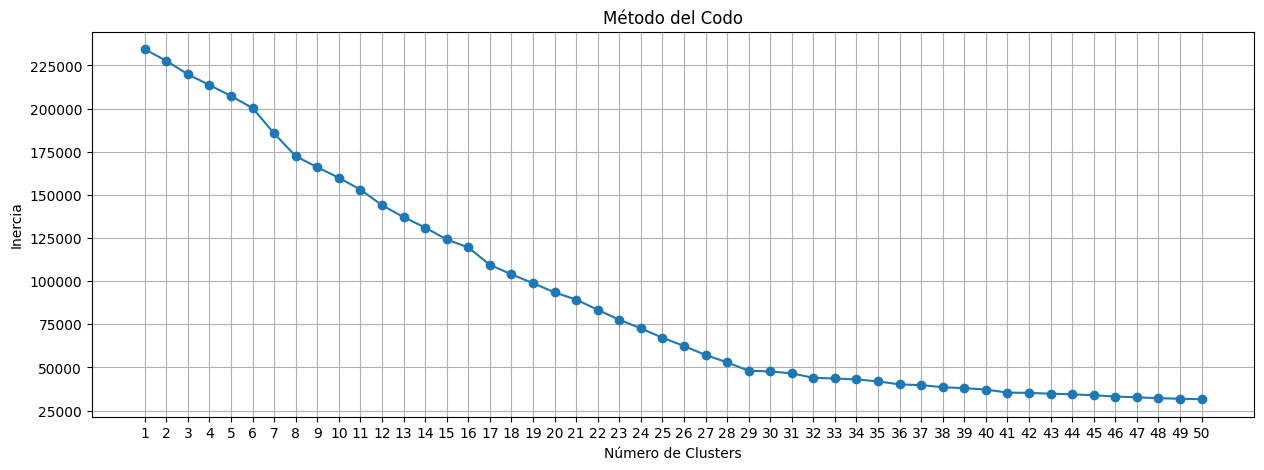

In [25]:
def plot_elbow_method(data, max_clusters=10, random_state=42):
    """
    Calcula y grafica el Método del Codo para encontrar el número óptimo de clusters.

    Parámetros:
        data: Dataset normalizado
        max_clusters: Número máximo de clusters a probar
        random_state: Semilla para reproducibilidad

    Retorna:
        Lista de inercias para cada número de clusters.
    """
    inertias = []
    cluster_range = range(1, max_clusters + 1)
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    # Graficar el Método del Codo
    plt.figure(figsize=(15, 5))
    plt.plot(cluster_range, inertias, marker='o')
    plt.title("Método del Codo")
    plt.xlabel("Número de Clusters")
    plt.ylabel("Inercia")
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()
    
    return inertias

# Aplicar el Método del Codo a los datos de entrenamiento
inertias = plot_elbow_method(train_data, max_clusters=50)


Número de Clusters: 15, Silhouette Score: 0.3318
Número de Clusters: 16, Silhouette Score: 0.3436
Número de Clusters: 17, Silhouette Score: 0.3477
Número de Clusters: 18, Silhouette Score: 0.3594
Número de Clusters: 19, Silhouette Score: 0.3647
Número de Clusters: 20, Silhouette Score: 0.3176
Número de Clusters: 21, Silhouette Score: 0.4035
Número de Clusters: 22, Silhouette Score: 0.4059
Número de Clusters: 23, Silhouette Score: 0.4096
Número de Clusters: 24, Silhouette Score: 0.4082
Número de Clusters: 25, Silhouette Score: 0.4184
Número de Clusters: 26, Silhouette Score: 0.4306
Número de Clusters: 27, Silhouette Score: 0.4119
Número de Clusters: 28, Silhouette Score: 0.4430
Número de Clusters: 29, Silhouette Score: 0.4533
Número de Clusters: 30, Silhouette Score: 0.4530
Número de Clusters: 31, Silhouette Score: 0.4548
Número de Clusters: 32, Silhouette Score: 0.4576
Número de Clusters: 33, Silhouette Score: 0.4590
Número de Clusters: 34, Silhouette Score: 0.4572


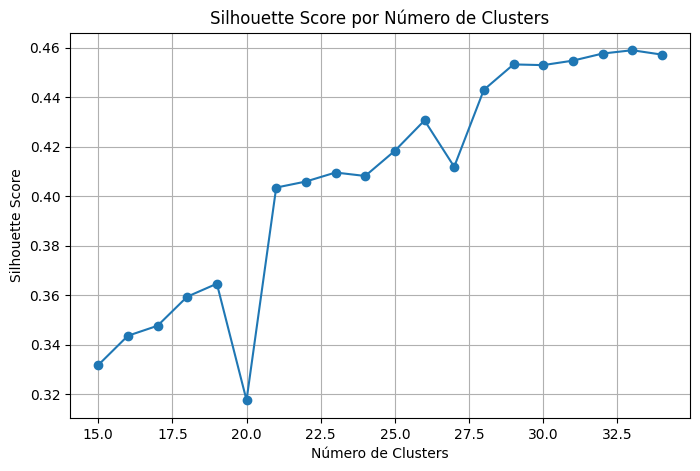

El número óptimo de clusters basado en el Silhouette Score es: 33


In [45]:
def calculate_silhouette_scores(data, cluster_range, random_state=42):
    """
    Calcula el Silhouette Score para un rango de clusters en K-Means.

    Parámetros:
        data: Dataset procesado (normalizado).
        cluster_range: Rango de valores para el número de clusters (lista o rango).
        random_state: Semilla para reproducibilidad.

    Retorna:
        Un diccionario con el número de clusters y sus respectivos Silhouette Scores.
    """
    silhouette_scores = {}
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores[n_clusters] = score
        print(f"Número de Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
    
    return silhouette_scores

# Rango de clusters a evaluar
cluster_range = range(15, 35)

# Calcular los Silhouette Scores
silhouette_scores = calculate_silhouette_scores(train_data, cluster_range)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Score por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Número óptimo de clusters
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f"El número óptimo de clusters basado en el Silhouette Score es: {optimal_clusters}")

Entrenamiento - Silhouette Score: 0.42, Calinski-Harabasz Index: 723.44
Validación - Silhouette Score: 0.43, Calinski-Harabasz Index: 436.61


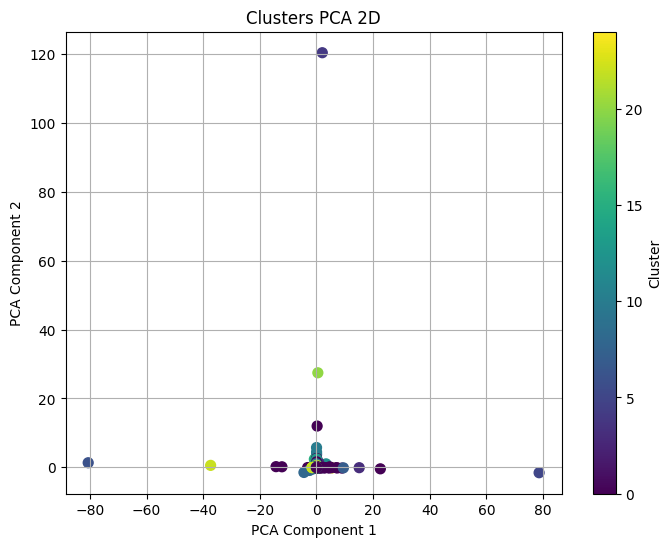

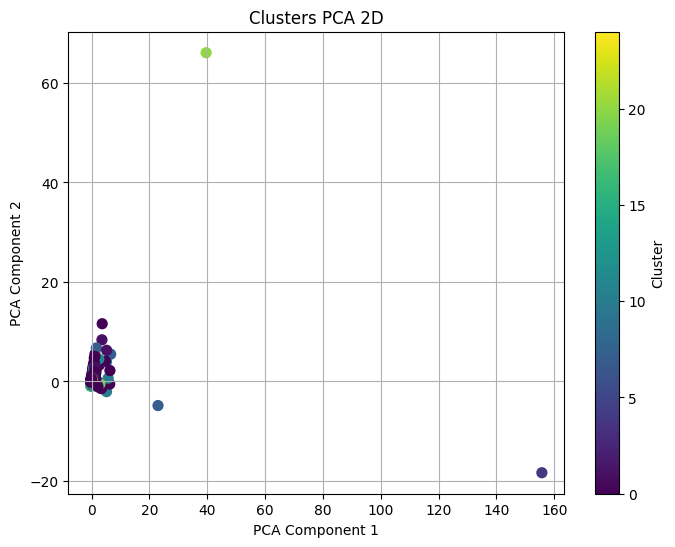

In [50]:
def kmeans_clustering(train_data, val_data, n_clusters=28, random_state=42):
    # Entrenar el modelo en los datos de entrenamiento
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    train_labels = kmeans.fit_predict(train_data)
    
    # Evaluación en los datos de entrenamiento
    train_silhouette = silhouette_score(train_data, train_labels)
    train_calinski = calinski_harabasz_score(train_data, train_labels)
    
    # Validación
    val_labels = kmeans.predict(val_data)
    val_silhouette = silhouette_score(val_data, val_labels)
    val_calinski = calinski_harabasz_score(val_data, val_labels)
    
    # Resultados
    results = {
        "train": {"silhouette": train_silhouette, "calinski": train_calinski, "labels": train_labels},
        "validation": {"silhouette": val_silhouette, "calinski": val_calinski, "labels": val_labels},
        "model": kmeans
    }
    
    return results

def plot_clusters_pca_2d(data, labels, title="Clusters PCA 2D"):
    """
    Reduce las dimensiones del dataset a 2 usando PCA y visualiza los clusters.

    Parámetros:
        data: Dataset original (más de 2 dimensiones).
        labels: Etiquetas de cluster para cada punto.
        title: Título del gráfico.
    """
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()

# Aplicar el modelo K-Means
n_clusters = 25  # Número de clusters
results = kmeans_clustering(train_data, val_data, n_clusters=n_clusters)

# Imprimir métricas
print(f"Entrenamiento - Silhouette Score: {results['train']['silhouette']:.2f}, Calinski-Harabasz Index: {results['train']['calinski']:.2f}")
print(f"Validación - Silhouette Score: {results['validation']['silhouette']:.2f}, Calinski-Harabasz Index: {results['validation']['calinski']:.2f}")

plot_clusters_pca_2d(train_data, results['train']['labels'])
plot_clusters_pca_2d(val_data, results['validation']['labels'])

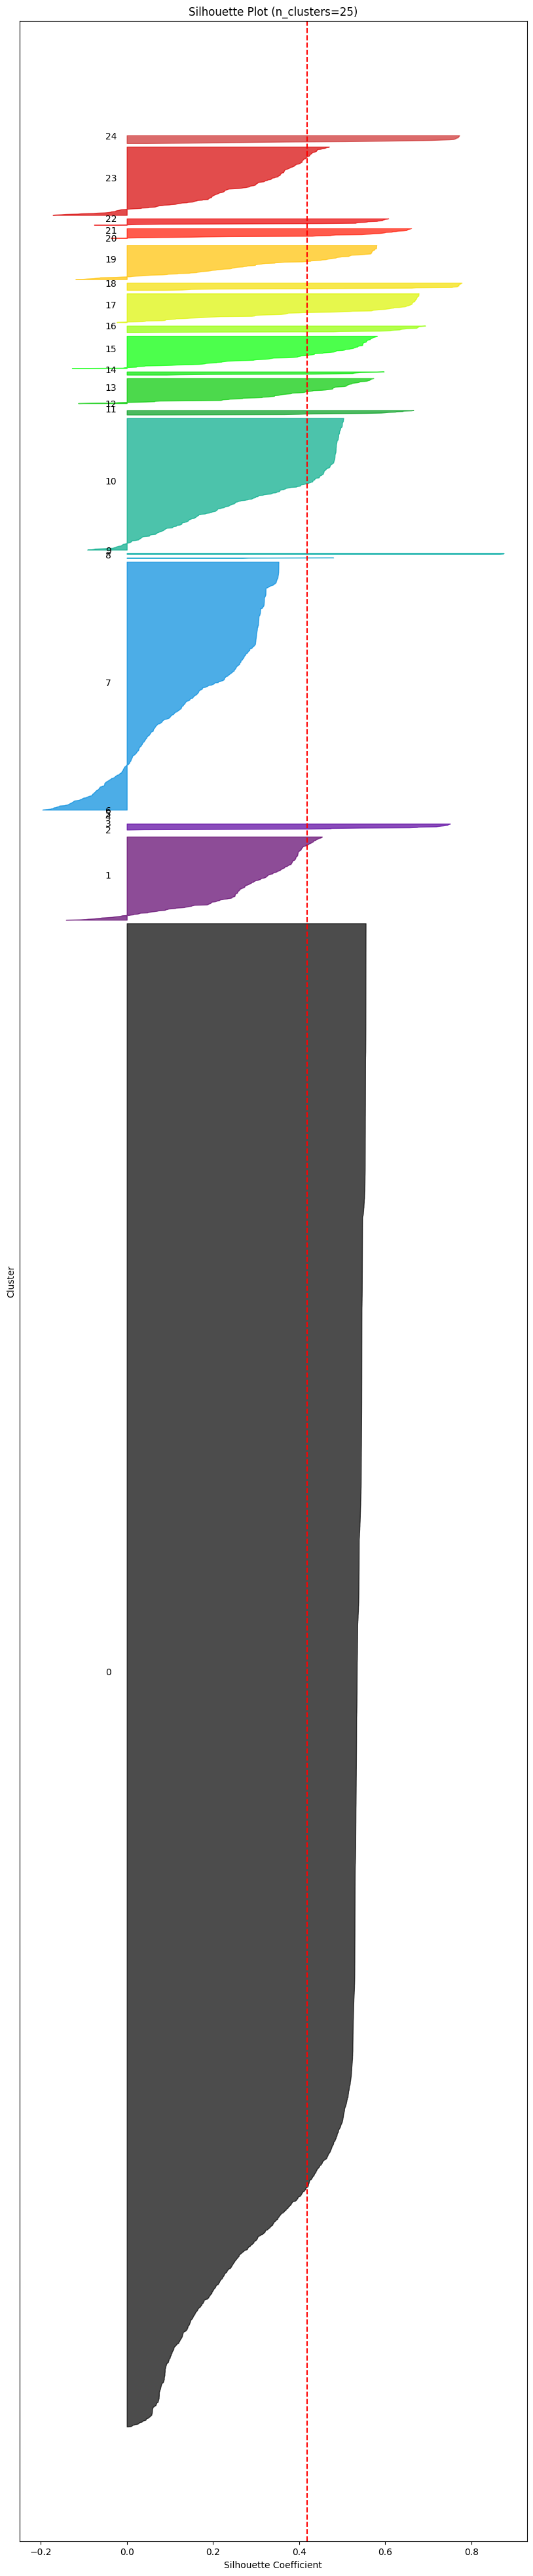

In [52]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

def plot_silhouette(data, labels, n_clusters):
    """
    Genera un Silhouette Plot para los clusters.

    Parámetros:
        data: Dataset original (normalizado).
        labels: Etiquetas de los clusters generados por el modelo.
        n_clusters: Número de clusters.
    """
    # Calcular los Silhouette Scores para cada punto
    silhouette_values = silhouette_samples(data, labels)
    avg_score = silhouette_values.mean()

    # Crear el Silhouette Plot
    plt.figure(figsize=(10, 50))
    y_lower = 10  # Inicio de las barras en el eje Y

    for i in range(n_clusters):
        # Filtrar Silhouette Scores para el cluster actual
        cluster_silhouette_values = silhouette_values[labels == i]
        cluster_silhouette_values.sort()

        # Definir la posición del cluster en el eje Y
        y_upper = y_lower + len(cluster_silhouette_values)

        # Color para este cluster
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiqueta del cluster
        plt.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_values), str(i))

        y_lower = y_upper + 10  # Espacio entre clusters

    # Dibujar la línea del promedio del Silhouette Score
    plt.axvline(x=avg_score, color="red", linestyle="--")
    plt.title(f"Silhouette Plot (n_clusters={n_clusters})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.yticks([])
    plt.show()

# Llamar al plot
plot_silhouette(train_data, results['train']['labels'], n_clusters=25)
